In [1]:
# imports
import sqlalchemy
from sqlalchemy import create_engine, Column, String, Integer, Numeric, MetaData, Table, type_coerce, ForeignKey, case
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
import csv
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
import numbers
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
import glob
import re
from os.path import isfile
import gsw

import createDBfromDFO_OPDB
%matplotlib inline

In [2]:
# definitions
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'DFOOPDB/'
dbname='DFO_OcProfDB'

In [3]:
# if PRISM.sqlite does not exist, run script to create it
if not isfile(basedir + dbname + '.sqlite'):
    import createDBfromDFO_OPDB
    createDBfromDFO_OPDB.main()
    import processDFO_OPDB
    processDFO_OPDB.main()
    print('done')
else:
    print('file exists')

file exists


In [4]:
Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created

In [5]:
Station=Base.classes.StationTBL
Obs=Base.classes.ObsTBL
JDFLocs=Base.classes.JDFLocsTBL
Calcs=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [6]:
Sal=case([(Obs.Salinity_Bottle!=None, Obs.Salinity_Bottle)], else_=
         case([(Obs.Salinity_T0_C0!=None, Obs.Salinity_T0_C0)], else_=
         case([(Obs.Salinity_T1_C1!=None, Obs.Salinity_T1_C1)], else_=
         case([(Obs.Salinity!=None, Obs.Salinity)], else_=
         case([(Obs.Salinity__Unknown!=None, Obs.Salinity__Unknown)], else_=Obs.Salinity__Pre1978)
        ))))
SalUnits=case([(Obs.Salinity_Bottle!=None, Obs.Salinity_Bottle_units)], else_=
         case([(Obs.Salinity_T0_C0!=None, Obs.Salinity_T0_C0_units)], else_=
         case([(Obs.Salinity_T1_C1!=None, Obs.Salinity_T1_C1_units)], else_=
         case([(Obs.Salinity!=None, Obs.Salinity_units)], else_=
         case([(Obs.Salinity__Unknown!=None, Obs.Salinity__Unknown_units)], else_=Obs.Salinity__Pre1978_units)
        ))))
SalFlag=case([(Obs.Salinity_Bottle!=None, Obs.Flag_Salinity_Bottle)], else_=
         case([(Obs.Salinity_T0_C0!=None, Obs.Flag_Salinity)], else_=
         case([(Obs.Salinity_T1_C1!=None, Obs.Flag_Salinity)], else_=
         case([(Obs.Salinity!=None, Obs.Flag_Salinity)], else_=
         case([(Obs.Salinity__Unknown!=None, Obs.Flag_Salinity)], else_=Obs.Quality_Flag_Sali)
        ))))
SA=case([(Calcs.Salinity_Bottle_SA!=None, Calcs.Salinity_Bottle_SA)], else_=
         case([(Calcs.Salinity_T0_C0_SA!=None, Calcs.Salinity_T0_C0_SA)], else_=
         case([(Calcs.Salinity_T1_C1_SA!=None, Calcs.Salinity_T1_C1_SA)], else_=
         case([(Calcs.Salinity_SA!=None, Calcs.Salinity_SA)], else_=
         case([(Calcs.Salinity__Unknown_SA!=None, Calcs.Salinity__Unknown_SA)], else_=Calcs.Salinity__Pre1978_SA)
        ))))

In [7]:
NO=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Nitrate_plus_Nitrite)], else_=Obs.Nitrate)
NOUnits=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Nitrate_plus_Nitrite_units)], else_=Obs.Nitrate_units)
NOFlag=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Flag_Nitrate_plus_Nitrite)], else_=Obs.Flag_Nitrate)
# Obs.Quality_Flag_Nitr does not match any nitrate obs
# ISUS not included in this NO; test separately

In [8]:
Tem=case([(Obs.Temperature!=None, Obs.Temperature)], else_=
         case([(Obs.Temperature_Primary!=None, Obs.Temperature_Primary)], else_=
         case([(Obs.Temperature_Secondary!=None, Obs.Temperature_Secondary)], else_=Obs.Temperature_Reversing)))
TemUnits=case([(Obs.Temperature!=None, Obs.Temperature_units)], else_=
         case([(Obs.Temperature_Primary!=None, Obs.Temperature_Primary_units)], else_=
         case([(Obs.Temperature_Secondary!=None, Obs.Temperature_Secondary_units)], 
              else_=Obs.Temperature_Reversing_units)))
TemFlag=Obs.Quality_Flag_Temp

In [9]:
Ox=case([(Calcs.Oxygen_umolL!=None, Calcs.Oxygen_umolL)], else_=Calcs.Oxygen_Dissolved_umolL)
OxFlag=case([(Calcs.Oxygen_umolL!=None, Obs.Quality_Flag_Oxyg)], else_=Obs.Flag_Oxygen_Dissolved)

In [10]:
Press=case([(Obs.Pressure!=None, Obs.Pressure)], else_=Obs.Pressure_Reversing)

In [13]:
# TS diagram based on example code, but using SA and CT
q=session.query(JDFLocs.ObsID, Obs.ID, SA, Tem, Press).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Calcs,Calcs.ObsID==Obs.ID).filter(and_(
            SA!=None,
            SA>0,
            SA<50,
            Tem!=None,
            Press!=None)).all()
ID1=[]
ID2=[]
S_A=[]
TC=[]
P=[]
for ID1x, ID2x, S_Ax, Tx, Px in q:
    S_A.append(float(S_Ax))
    TC.append(gsw.CT_from_t(S_Ax,Tx,Px))
S_A=np.array(S_A)
TC=np.array(TC)

/home/eolson/anaconda3/envs/teos10/lib/python3.4/site-packages/ipykernel/__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


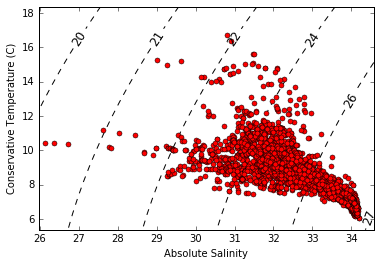

In [14]:
# TS diagram example:

# Create variables with user-friendly names
temp  = TC
salt  = S_A
 
# Figure out boudaries (mins and maxs)
smin = salt.min() - (0.01 * salt.min())
smax = salt.max() + (0.01 * salt.max())
tmin = temp.min() - (0.1 * temp.max())
tmax = temp.max() + (0.1 * temp.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = round((smax-smin)/0.1+1,0)
ydim = round((tmax-tmin)+1,0)
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],gsw.t_from_CT(si[i],ti[j],0),0)
 
# Substract 1000 to convert to sigma-t
dens = dens - 1000
 
# Plot data ***********************************************
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%1.0f') # Label every second level
 
ax1.plot(salt,temp,'or',markersize=5)
 
ax1.set_xlabel('Absolute Salinity')
ax1.set_ylabel('Conservative Temperature (C)')

# Ammonium: use Obs.Ammonium (umol/L)

In [20]:
q=session.query(Obs.Ammonia, Obs.Ammonia_units, Obs.Ammonium, Obs.Ammonium_units, func.count()).\
        filter(or_(Obs.Ammonia!=None,Obs.Ammonium!=None)).\
        group_by(Obs.Ammonia_units,Obs.Ammonium_units).all()
for row in q:
    print(row)

(None, None, 0.16, 'umol/L', 3051)
(0.7, 'microg-at/l', None, None, 1163)


In [ ]:
fig, axs = plt.subplots(2,2)

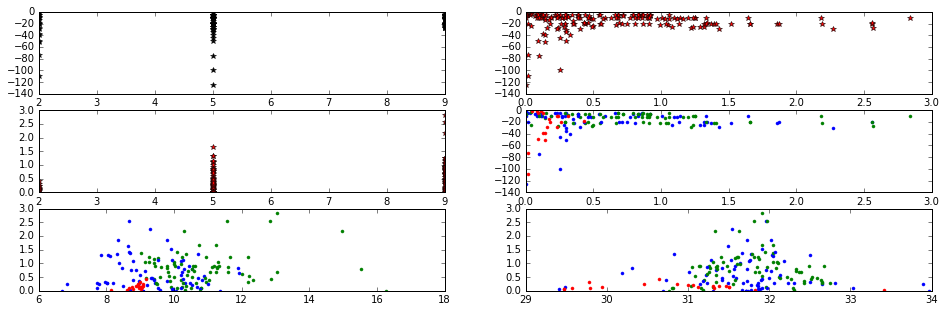

In [41]:
q=session.query(JDFLocs.ObsID, Station.StartYear,Station.StartMonth,Press, Obs.Depth,
                Obs.Ammonium,Obs.Ammonium_units,Tem,Sal).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Station,Station.ID==Obs.StationTBLID).\
        filter(Obs.Ammonium!=None).all()
fig, axs = plt.subplots(3,2,figsize=(16,5))
for row in q:
    #print(row)
    axs[0,0].plot(row[2],-row[3],'k*')
    axs[0,1].plot(row[5],-row[3],'r*')
    if row[3]<20:
        axs[1,0].plot(row[2],row[5],'r*')
    if row[2]==5:
        axs[1,1].plot(row[5],-row[3],'b.')
        axs[2,0].plot(row[7],row[5],'b.')
        axs[2,1].plot(row[8],row[5],'b.')
    elif row[2]==2:
        axs[1,1].plot(row[5],-row[3],'r.')
        axs[2,0].plot(row[7],row[5],'r.')
        axs[2,1].plot(row[8],row[5],'r.')
    else:
        axs[1,1].plot(row[5],-row[3],'g.')
        axs[2,0].plot(row[7],row[5],'g.')
        axs[2,1].plot(row[8],row[5],'g.')

DON:

In [64]:
q=session.query(Station.StartYear,Station.StartMonth,Press, Station.Lat, Station.Lon,Obs.Depth,
                Obs.Nitrogen_Dissolved_Organic,Obs.Nitrogen_Dissolved_Organic_units,Tem,Sal).\
        select_from(Obs).join(Station,Station.ID==Obs.StationTBLID).\
        filter(Obs.Nitrogen_Dissolved_Organic!=None).filter(Obs.Nitrogen_Dissolved_Organic>=0).\
        filter(Station.Lat!=None).filter(Station.Lon!=None).\
        filter(Station.Lat<48.8).filter(Station.Lon<-125).all()

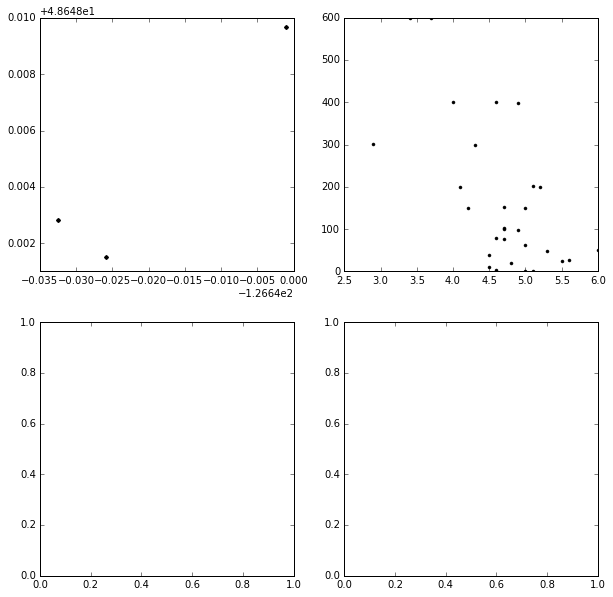

In [65]:

fig, axs = plt.subplots(2,2,figsize=(10,10))
for row in q:
    axs[0,0].plot(row[4],row[3],'k.')
    axs[0,1].plot(row[6],row[2],'k.')

In [15]:
q=session.query(JDFLocs.ObsID,Station.StartYear,Station.StartMonth,Press,
                func.avg(NO)).\
        select_from(Obs).join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Calcs,Calcs.ObsID==Obs.ID).\
        join(Station,Station.ID==Obs.StationTBLID).\
        filter(NO!=None).filter(NO>=0).\
        filter(Press<10).group_by(Station.StartMonth).all()

(25699, 2002.0, 1.0, 5.2, 9.766666666666666)
(29621, 2003.0, 2.0, 5.0, 4.442857142857143)
(35731, 2005.0, 3.0, 9.9, 3.0750000000000006)
(59417, 2000.0, 4.0, 9.6, 11.92420289855072)
(42809, 2008.0, 5.0, 4.8, 8.002678571428572)
(41644, 2007.0, 6.0, 6.5, 17.761818181818178)
(60008, 2000.0, 7.0, 5.4, 22.7875)
(60296, 2000.0, 8.0, 1.7, 13.963636363636363)
(43267, 2008.0, 9.0, 4.3, 19.37224137931034)
(41941, 2007.0, 10.0, 6.9, 17.389411764705883)
(42247, 2007.0, 11.0, 6.6, 12.955555555555556)
(35178, 2004.0, 12.0, 9.8, 7.321052631578948)


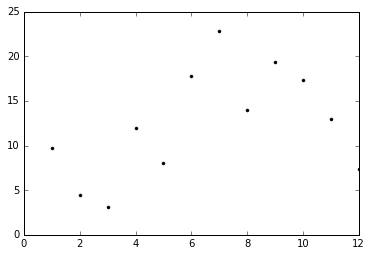

In [19]:
for row in q:
    print(row)
    plt.plot(row[2],row[4],'k.')

In [66]:
q=session.query(JDFLocs.ObsID, Obs.ID, SA, Sal, Tem, Press).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Calcs,Calcs.ObsID==Obs.ID).filter(and_(
            SA!=None,
            Tem!=None,
            Press!=None)).filter(SA>40).all()
for row in q:
    print(row)

(6334, 6334, 54.82919511370604, 54.5674, 10.6817, 27.6)


In [67]:
q=session.query(JDFLocs.ObsID, Obs.sourceFile, Obs.Depth, SA, Obs.Salinity_Bottle, Obs.Salinity, Obs.Salinity_T0_C0, 
               Obs.Salinity_T1_C1, Obs.Salinity__Pre1978, Obs.Salinity__Unknown).select_from(Obs).\
        join(JDFLocs,JDFLocs.ObsID==Obs.ID).join(Calcs,Calcs.ObsID==Obs.ID).filter(and_(
            SA!=None,
            Tem!=None,
            Press!=None)).filter(SA>40).all()
for row in q:
    print(row)

(6334, 'UBC EO data request 20160113 a/2010-21-0009.che', None, 54.82919511370604, None, None, 54.5674, None, None, None)


In [68]:
qJDFLoc=session.query(Obs.ID, Station.ID).filter(
    and_(
        Station.Lat > 48.2,
        Station.Lat < 48.8,
        Station.Lon > -125.2,
        Station.Lon < -124.2
        )).join(Station, Obs.StationTBLID==Station.ID)
print(qJDFLoc.count())

3404


In [69]:
test=session.query(JDFLocs).count()
print(test)

3404


In [70]:
qdata=session.query(JDFLocs.ObsID, Station.Lat, Station.Lon, Obs.Depth, Obs.Pressure, Tem, Sal, NO, 
            Oxy_mLL).join(Obs, JDFLocs.ObsID==Obs.ID).join(Station, Obs.StationTBLID==Station.ID).filter(and_(
                        Obs.Depth>50,
                        Tem!=None, 
                        Sal!=None,
                        NO!=None,
                        Oxy_mLL!=None)
                        )
print(qdata.count())

NameError: name 'Oxy_mLL' is not defined

In [ ]:
Lat=[]
Lon=[]
z=[]
P=[]
T=[]
S=[]
N=[]
O=[]
for row in qdata.all():
    Lat.append(row[1])
    Lon.append(row[2])
    z.append(row[3])
    P.append(row[4])
    T.append(float(row[5]))
    S.append(float(row[6]))
    N.append(float(row[7]))
    O.append(float(row[8]))

In [ ]:
print(T[0])

In [ ]:
N=np.array(N)
S=np.array(S)
T=np.array(T)
O=np.array(O)

In [ ]:
plt.plot(S,N,'.')
plt.xlabel('S')
plt.ylabel('N')

In [ ]:
plt.plot(T,N,'.')
plt.xlabel('T')
plt.ylabel('N')

In [ ]:
plt.plot(O,N,'.')
plt.xlabel('O')
plt.ylabel('N')

In [ ]:
a=np.vstack([T,S,O,np.ones(len(T))]).T
m = np.linalg.lstsq(a,N)[0]
mT, mS, mO, mC = m
print(mT, mS, mO, mC)

In [ ]:
plt.plot(N,np.dot(a,m),'.')
plt.xlabel('NO')
plt.ylabel('NO, linear model')
SSE=np.dot((NO-np.dot(a,m)),(NO-np.dot(a,m)).T)
plt.title('Linear Model: NO(T,S)')
print('SSE=', SSE)
plt.plot(np.array([0,40]), np.array([0, 40]),'r-')

In [ ]:
session.close()
engine.dispose()